<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/RL-PortfolioOpt_StocVol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import numpy.matlib


import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import copy



In [2]:
#Setting seed
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(0)

In [3]:
## Function for Heston vol 

from IPython.core.debugger import set_trace

params = {
    "S0" : np.array([1]),
    "mu" : np.array([0.03]),    
    "rho" : -.2,
    "kappa" : np.array([[2]]),
    "theta" : np.array([[0.3]]),
    "xi" : np.array([[1.0]]),
    "v0" : np.array([0.2**2]),
    "delta" : np.array([0.7]),
    "rf" : 0.00
    }

# params = {
#     "S0" : np.array([100]),
#     "mu" : np.array([0.05]),
#     "sigma" : np.array([0.8]),
#     "rho" : -.2,
#     "kappa" : np.array([[.3]]),
#     "theta" : np.array([[.2]]),
#     "xi" : np.array([[.2]]),
#     "v0" : np.array([0.2]),
#     "delta" : np.array([0.7]),
#     "rf" : 0.01,
#     }

params_Q = copy.copy(params)    

def SimPathStocVol ( Ndt, params, T, Nsims):

    # Generate a Monte Carlo simulation for the Heston model
    #set_trace()
    dt = T/Ndt
    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, params["rho"]], [params["rho"], 1]])
    W   = np.random.multivariate_normal(MU, COV, ( Ndt +1, Nsims))
    W_S = W[:,:,0]
    W_v = W[:,:,1]

    # Generate paths
    vt    = np.zeros((Ndt +1, Nsims))
    vt[0,:] = params["v0"]
    St    = np.zeros((Ndt +1, Nsims))
    St[0,:] = params["S0"]
    #print(St[0])
    #set_trace()
    for t in range(1, Ndt +1):        
#         vt[t,:] = np.abs(vt[t-1,:] + params["kappa"]*(params["theta"]-np.abs(vt[t-1,:]))*dt \
#                          + params["xi"]*np.sqrt(np.abs(vt[t-1,:]))*W_v[t,:]*np.sqrt(dt))                                            
#         vt[t,:] = vt[t-1,:] + params["kappa"]*(params["theta"]- np.maximum(0,vt[t-1,:]) )*dt\
#          + params["xi"]*np.sqrt(np.maximum(0,vt[t-1,:]))*W_v[t,:]*np.sqrt(dt)
        #With Milestein correction term 
#         vt[t,:] = vt[t-1,:] + params["kappa"]*(params["theta"]- np.maximum(0,vt[t-1,:]) )*dt \
#         + params["xi"]*np.sqrt(np.maximum(0,vt[t-1,:]))*W_v[t,:]*np.sqrt(dt) +\
#         0.25 * params["xi"]**2*dt(W_v[t,:]**2-1)
        
        vt[t,:] = vt[t-1,:] + params["kappa"]*(params["theta"]- np.maximum(0,vt[t-1,:]))*dt + \
        params["xi"]*np.sqrt(np.maximum(0,vt[t-1,:]))*W_v[t,:]*np.sqrt(dt) \
        + 0.25 * params["xi"]**2*dt*(W_v[t,:]**2-1) 
        
        
        St[t,:] = St[t-1,:]*np.exp((params["mu"] - 0.5*vt[t-1,:])*dt + np.sqrt(vt[t-1,:]*dt)*W_S[t,:])
        #print(St[t-1])
        
    #set_trace()
    #import pandas as pd
    #pd.DataFrame(vt).to_csv('vol.csv')
        
    St = St.reshape(Ndt +1, Nsims, 1 )
    t = np.linspace(0,T,Ndt+1)    
    return t, St

In [4]:
Ndt = 252
Nsims = 1000
MU  = np.array([0, 0])
COV = np.matrix([[1, params["rho"]], [params["rho"], 1]])
W   = np.random.multivariate_normal(MU, COV, ( Ndt +1, Nsims))
W[:,:,0].shape

(253, 1000)

In [5]:
t, S = SimPathStocVol( Ndt=252, params = params, T=5, Nsims= 100)

In [6]:
S.shape

(253, 100, 1)

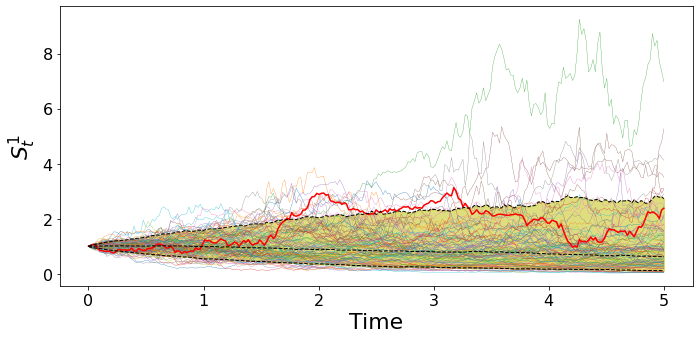

In [7]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPathStocVol(Ndt=252, params = params, T=5, Nsims = 1000)
#t, S = SimPath(Ndt=252, params = params, T=5, Nsims = 1000)
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [8]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [9]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p*alpha* torch.mean(X[X<=LQtl]) \
                        + (1-p) * (1-beta)*torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [10]:
# from a minibatch compute the Wasserstein Distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

In [11]:
# given an ANN run a simulation and compute the riskmeasure
from IPython.core.debugger import set_trace

def SimRM(net, Ndt, T, Nsims, params, device):
    
    t, S = SimPathStocVol(Ndt, params, T=T, Nsims=Nsims)  
      
    #t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    #set_trace()
    # initial investment amount
    X0 = 1
    
    num_asset = S.shape[2]
    dt = t[1]-t[0]
    
    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
    S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]
    
    #Benchmark Delta and return
    Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                                 dtype=torch.float, requires_grad=False, device=device)
    # note only 90% invested in risky assets here... 10% in risk-free
    delta = torch.tensor(params["delta"],requires_grad=False, device=device)
    delta_r = 1 - torch.sum(delta)
    Delta_t += delta 

    # accumulate returns as we go along
    Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)
    
    BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
    BenchmarkVal_path[0,:]  = X0
    BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
    BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)
    #print(torch.mean(BenchmarkVal_path,1))
    #
    # Getting the portfolio weights using benchmark value and time as features
    #
    x=np.zeros((Ndt+1, Nsims, 2))   
    #set_trace()
    
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    xt[:,:,1] = BenchmarkVal_path/X0
    
    wt = net(xt)    
    
    # the candidate portolio
    Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)
    
    PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
    PortfolioVal_path[0,:] = X0
    PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
    PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)
        
    
    # Compute the risk measure and wasstertein Distance for the computation
    wass_dist = getWassDistance(PortfolioVal_T, BenchmarkVal_T)
    RiskMeasure = GetRiskMeasure(PortfolioVal_T, "alpha-beta") 
    
    return wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, t, BenchmarkVal_path.cpu().detach().numpy(), PortfolioVal_path.cpu().detach().numpy()

In [12]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists(X, Y, t, X_path, Y_path):
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    bins = np.linspace(0,4,50)
    
    sns.distplot(Xcp, hist=True, kde=True,  bins=bins, label='Benchmark')
    sns.distplot(Ycp,  hist=True, kde=True, bins=bins, label='Portfolio')  
    
    plt.axvline(np.quantile(Xcp, 0.05),color='k',linewidth=0.5)
    plt.axvline(np.quantile(Ycp, 0.05),color='r',linewidth=0.5)
    
    plt.legend()
    plt.xlim(0,4)
    

    plt.subplot(1,3,2)
    plt.fill_between(t, np.quantile(X_path,0.1,axis=1).T, np.quantile(X_path,0.9,axis=1).T, color='y', alpha=0.5)
    plt.fill_between(t, np.quantile(Y_path,0.1,axis=1).T, np.quantile(Y_path,0.9,axis=1).T, color='g', alpha=0.5)
    plt.plot(t,X_path[:,0], label='Benchmark', color='r')
    plt.plot(t,np.quantile(X_path,[0.1,0.5,0.9],axis=1).T, '--y')
    plt.plot(t,Y_path[:,0], label='Portfolio', color='k')
    plt.plot(t,np.quantile(Y_path,[0.1,0.5,0.9],axis=1).T, '--g')
    
    plt.legend()
    
    
    plt.subplot(1,3,3)
    xs = [min(Xcp), max(Xcp)]
    plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


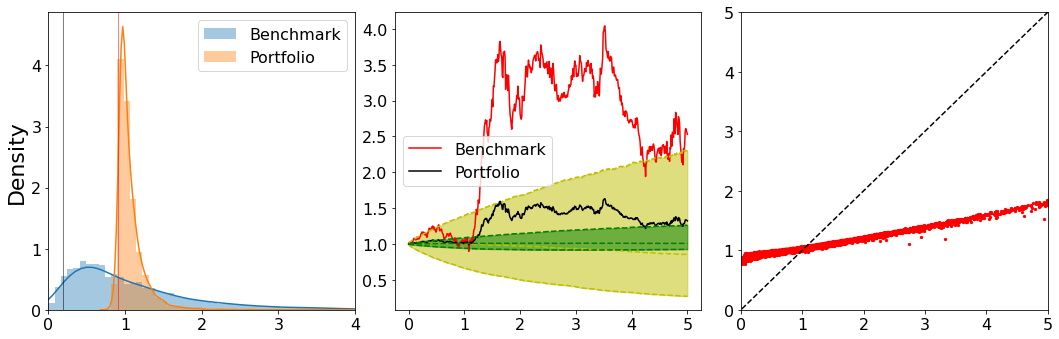

In [13]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)


In [14]:
PortfolioVal_path.shape

(501, 10000)

In [15]:
torch.cuda.is_available()

True

...........10 duaration =  9.197  secs
Wass Dist: 0.577 Risk Measure: -10.177 Loss: 47.565


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


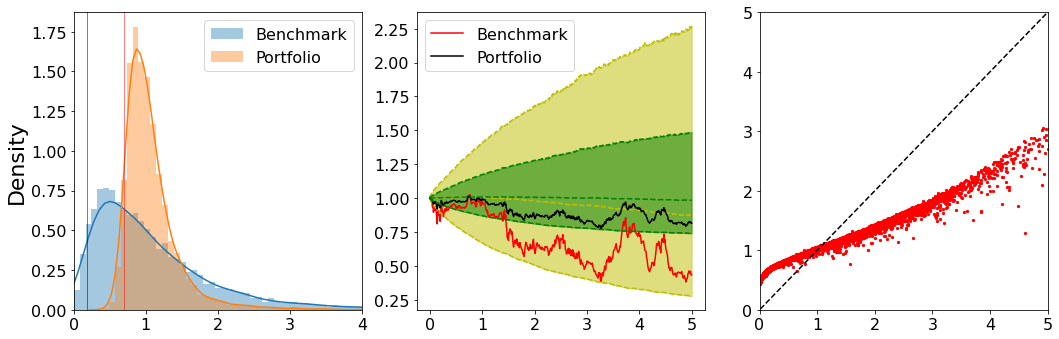

1.0722232 1.0308164

..........20 duaration =  10.655  secs
Wass Dist: 0.531 Risk Measure: -10.106 Loss: 42.996


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


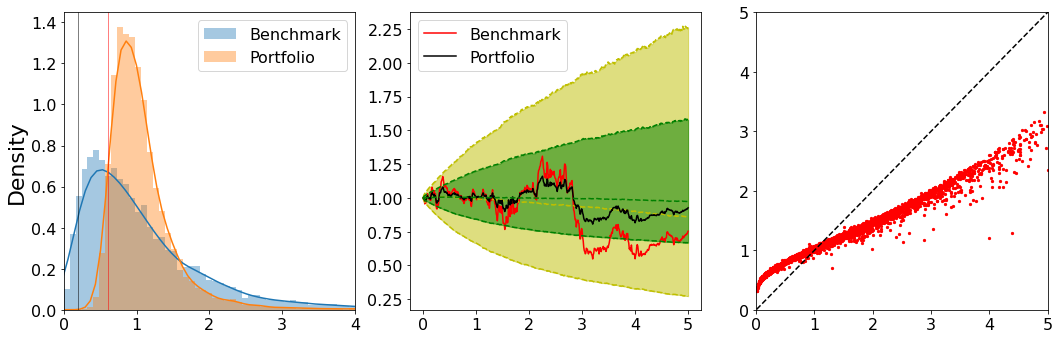

1.0810541 1.0426445

..........30 duaration =  10.732  secs
Wass Dist: 0.601 Risk Measure: -9.827 Loss: 50.287


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


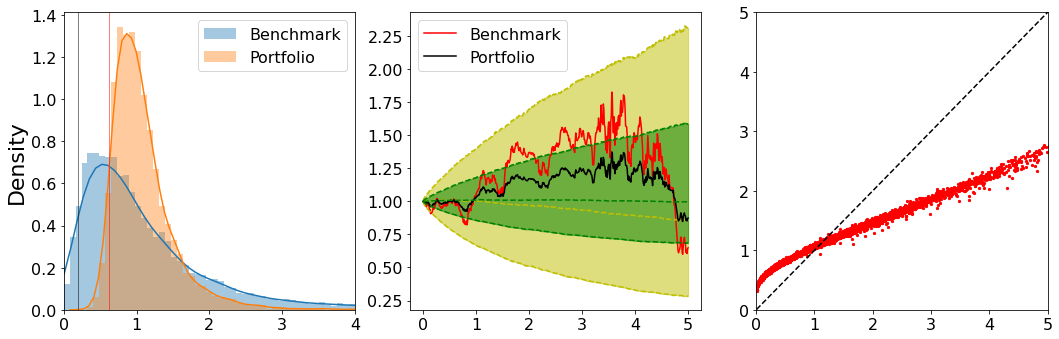

1.060534 1.0268577

..........40 duaration =  10.640  secs
Wass Dist: 0.547 Risk Measure: -9.721 Loss: 45.000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


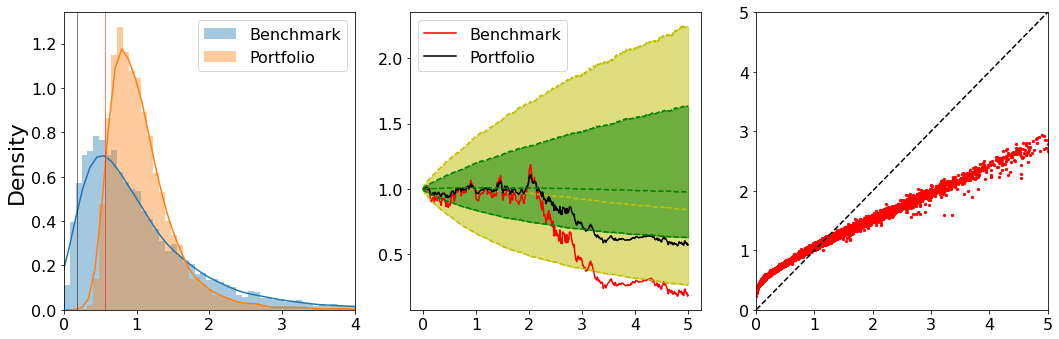

1.0648603 1.0319757

..........50 duaration =  10.633  secs
Wass Dist: 0.349 Risk Measure: -9.899 Loss: -9.899


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


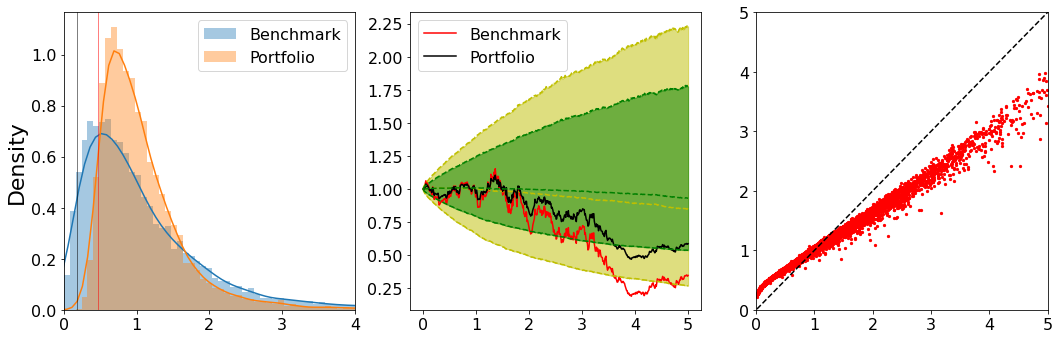

1.0720358 1.0439024

..........60 duaration =  10.774  secs
Wass Dist: 0.351 Risk Measure: -10.648 Loss: -10.648


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


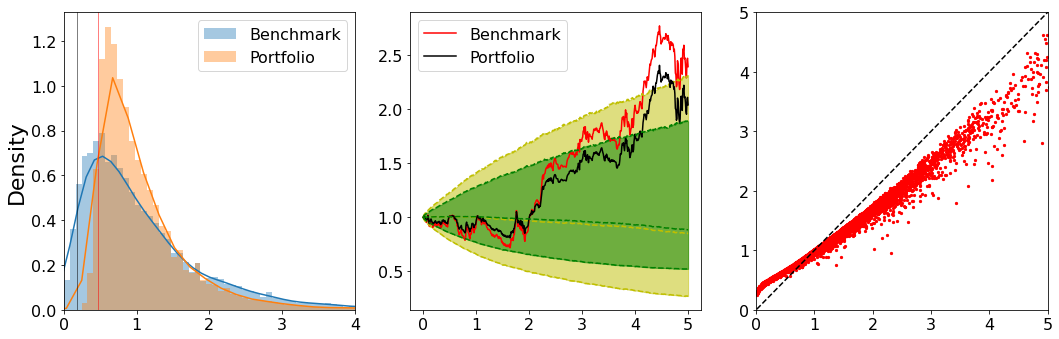

1.0605717 1.0382777

..........70 duaration =  10.804  secs
Wass Dist: 0.344 Risk Measure: -10.437 Loss: -10.437


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


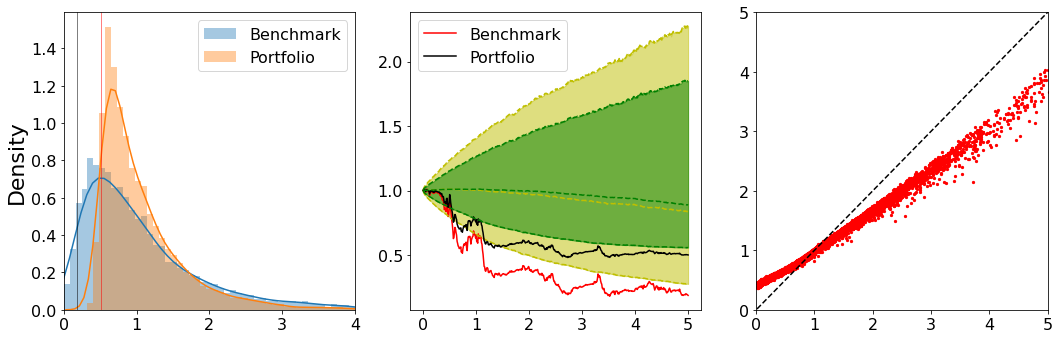

1.0679984 1.0455374

..........80 duaration =  10.722  secs
Wass Dist: 0.378 Risk Measure: -10.557 Loss: -10.557


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


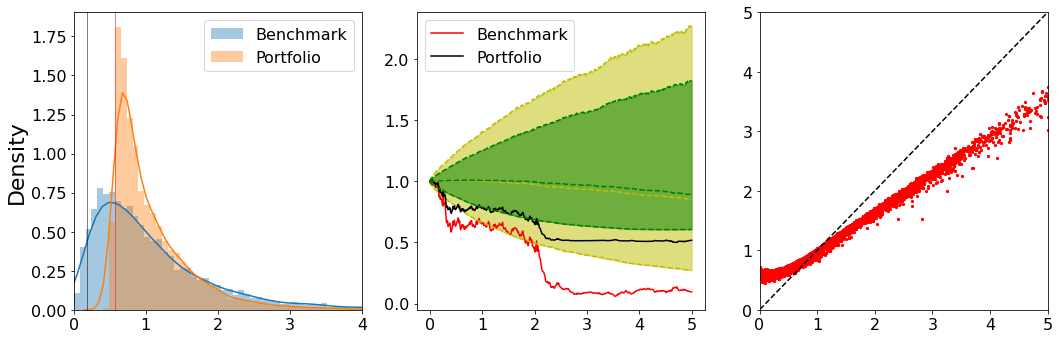

1.0793821 1.0499821

..........90 duaration =  10.680  secs
Wass Dist: 0.370 Risk Measure: -10.787 Loss: -10.787


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


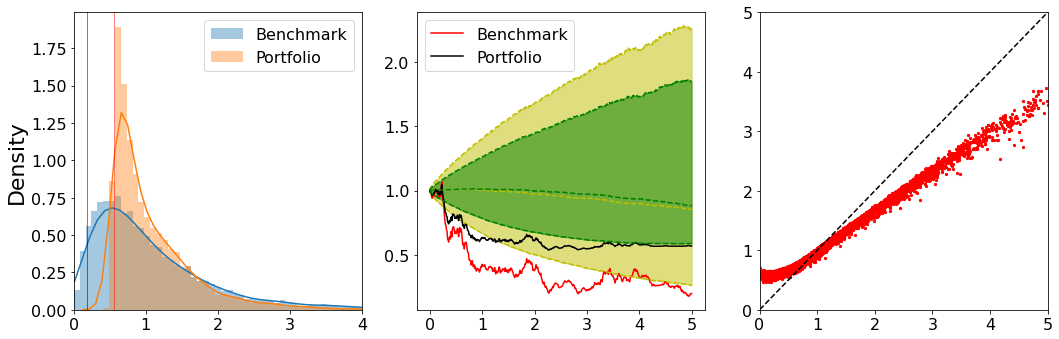

1.0672497 1.0426499

..........100 duaration =  10.657  secs
Wass Dist: 0.420 Risk Measure: -10.883 Loss: 31.140


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


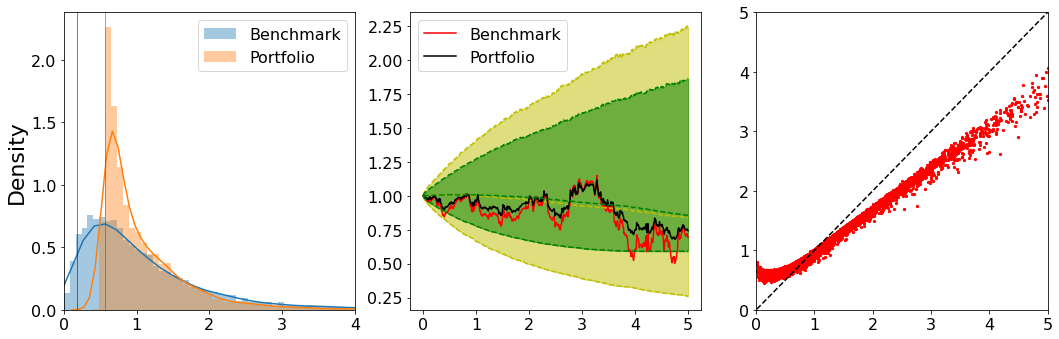

1.0650189 1.0428648

..........110 duaration =  10.682  secs
Wass Dist: 0.320 Risk Measure: -10.938 Loss: -10.938


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


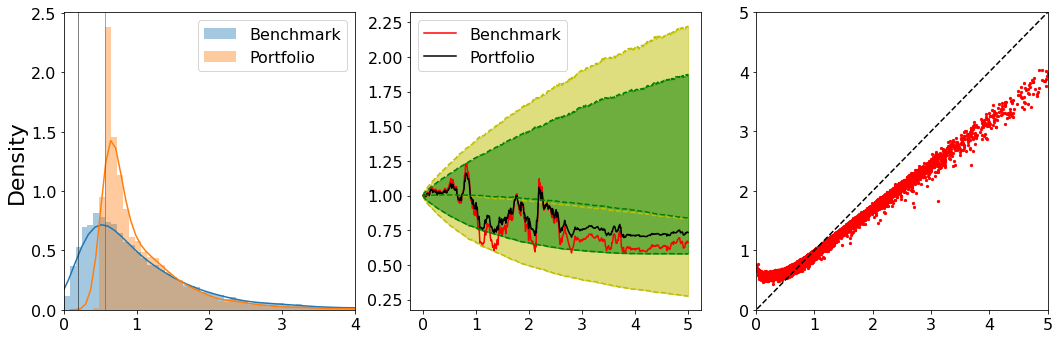

1.0710044 1.0476052

..........120 duaration =  10.699  secs
Wass Dist: 0.324 Risk Measure: -11.306 Loss: -11.306


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


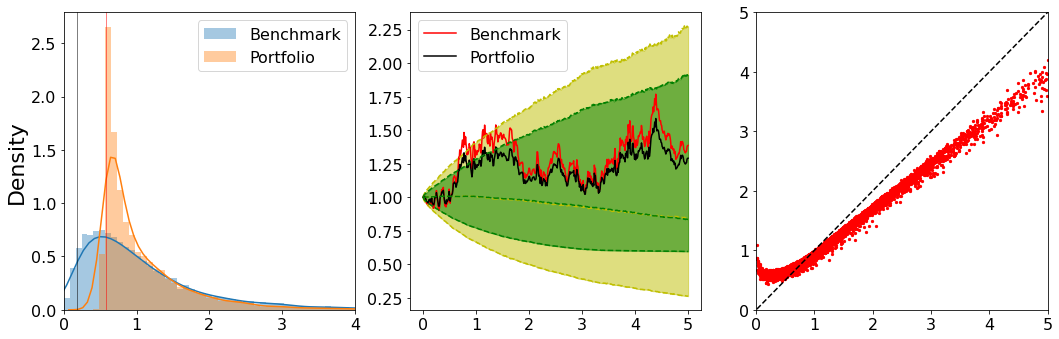

1.0623896 1.0407674

..........130 duaration =  10.752  secs
Wass Dist: 0.338 Risk Measure: -11.384 Loss: -11.384


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


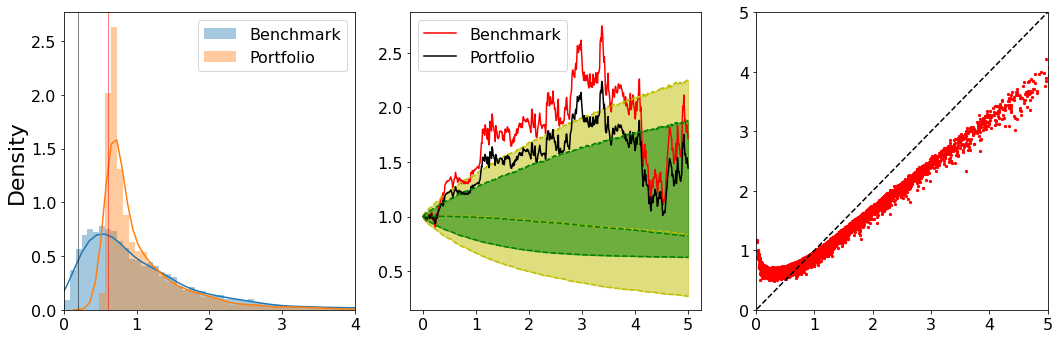

1.082903 1.053272

..........140 duaration =  10.775  secs
Wass Dist: 0.356 Risk Measure: -11.799 Loss: -11.799


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


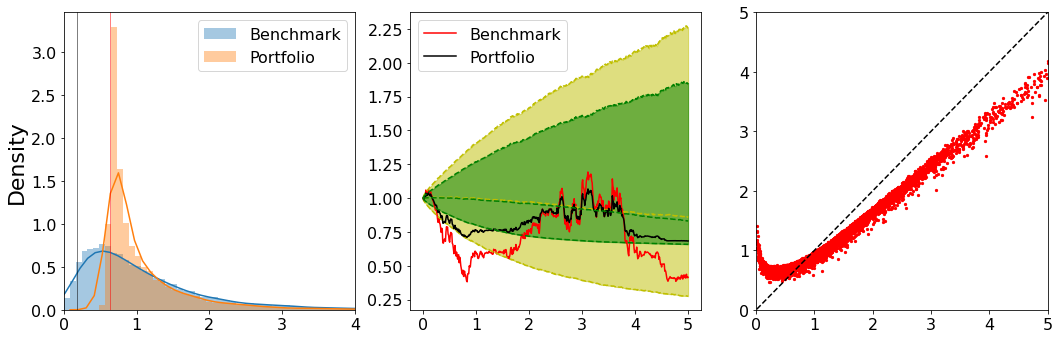

1.0643207 1.0385929

..........150 duaration =  10.721  secs
Wass Dist: 0.358 Risk Measure: -11.679 Loss: -11.679


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


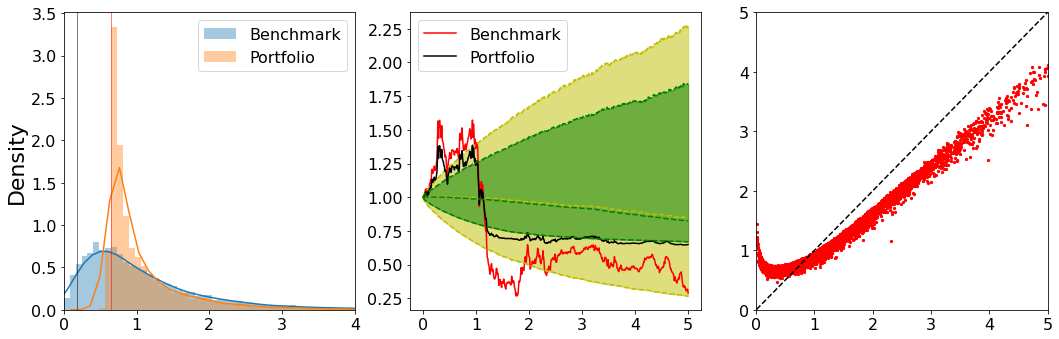

1.0619738 1.0391276

..........160 duaration =  10.784  secs
Wass Dist: 0.347 Risk Measure: -11.781 Loss: -11.781


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


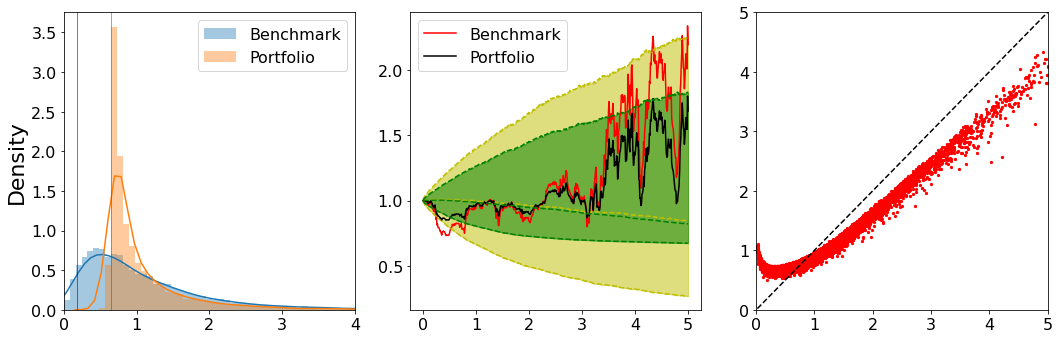

1.0742309 1.0436188

..........170 duaration =  10.696  secs
Wass Dist: 0.341 Risk Measure: -12.233 Loss: -12.233


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


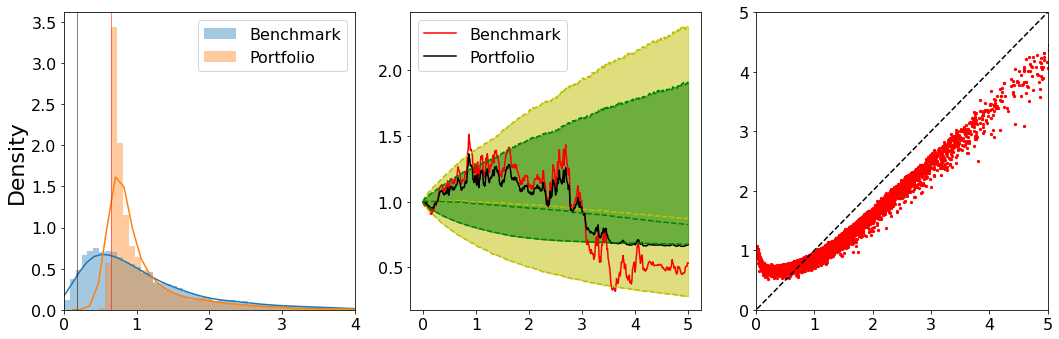

1.0679388 1.0380826

..........180 duaration =  10.870  secs
Wass Dist: 0.385 Risk Measure: -11.446 Loss: -11.446


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


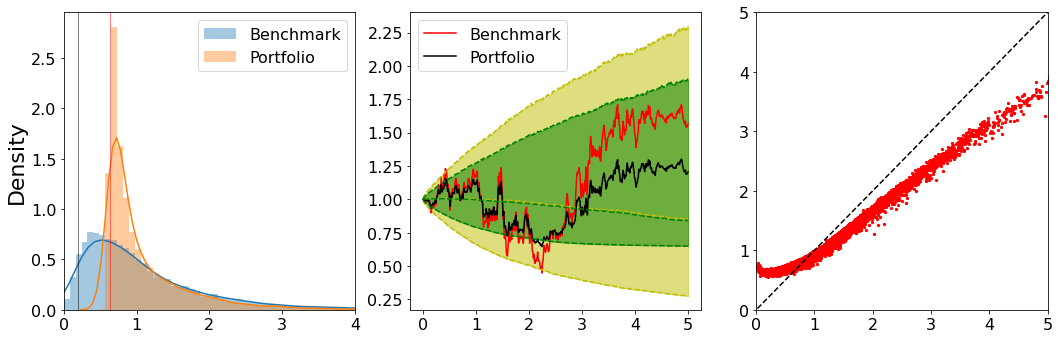

1.0747535 1.0493196

..........190 duaration =  10.754  secs
Wass Dist: 0.306 Risk Measure: -10.650 Loss: -10.650


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


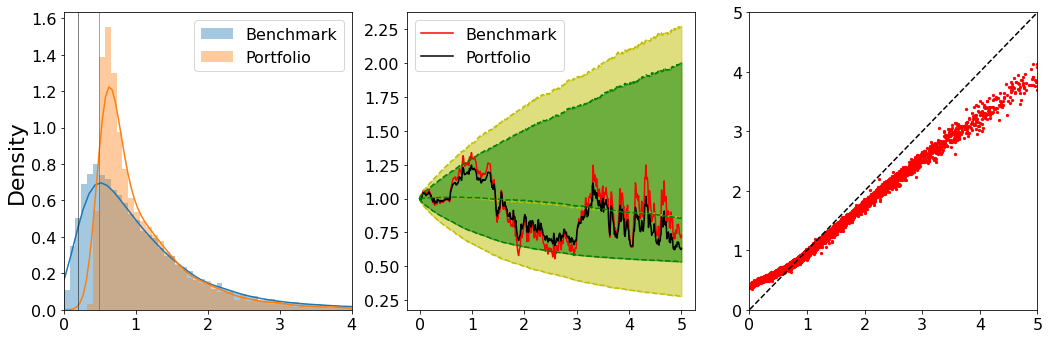

1.0668962 1.0469426

..........200 duaration =  10.821  secs
Wass Dist: 0.327 Risk Measure: -10.789 Loss: -10.789


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


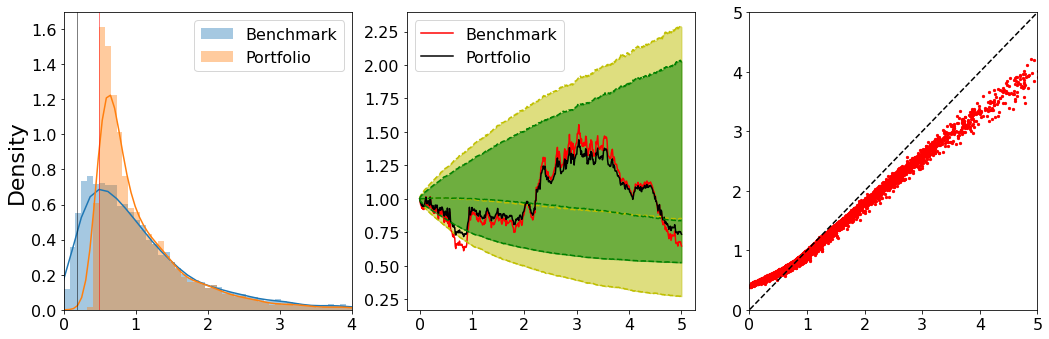

1.0840262 1.0608674

..........210 duaration =  10.746  secs
Wass Dist: 0.301 Risk Measure: -11.274 Loss: -11.274


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


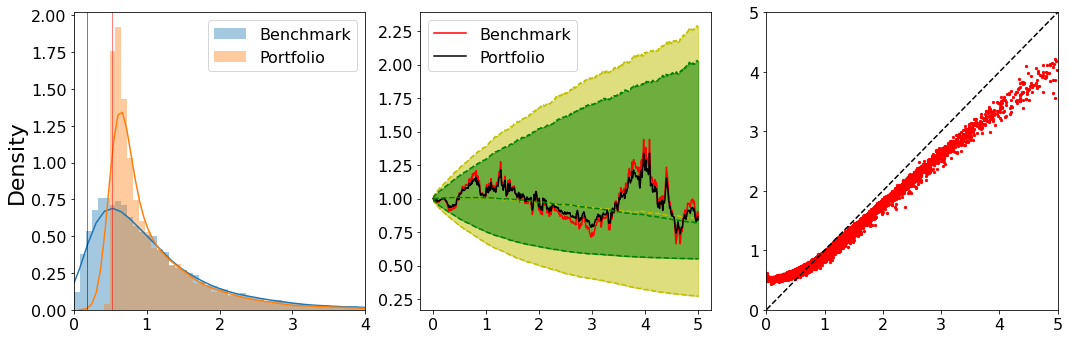

1.0681018 1.0486085

..........220 duaration =  10.772  secs
Wass Dist: 0.294 Risk Measure: -11.582 Loss: -11.582


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


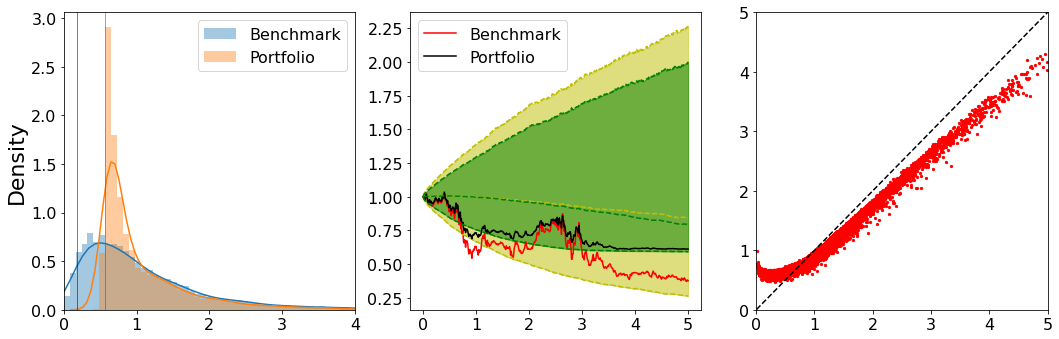

1.0828228 1.0595856

..........230 duaration =  10.781  secs
Wass Dist: 0.322 Risk Measure: -11.837 Loss: -11.837


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


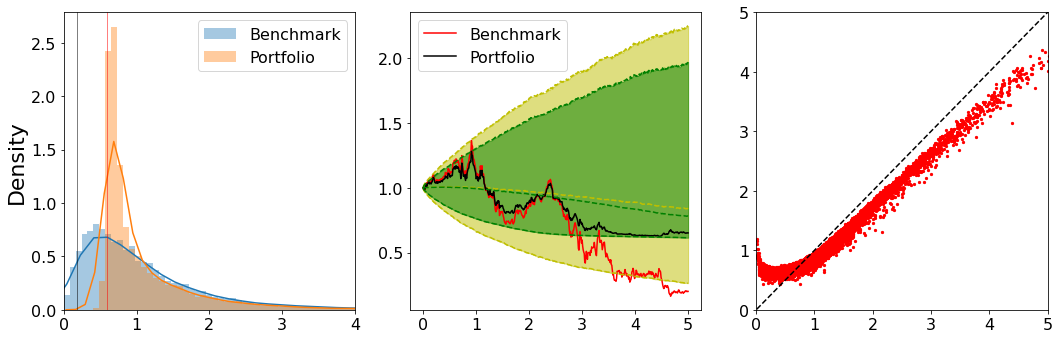

1.057149 1.0378717

..........240 duaration =  10.722  secs
Wass Dist: 0.498 Risk Measure: -12.318 Loss: 37.479


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


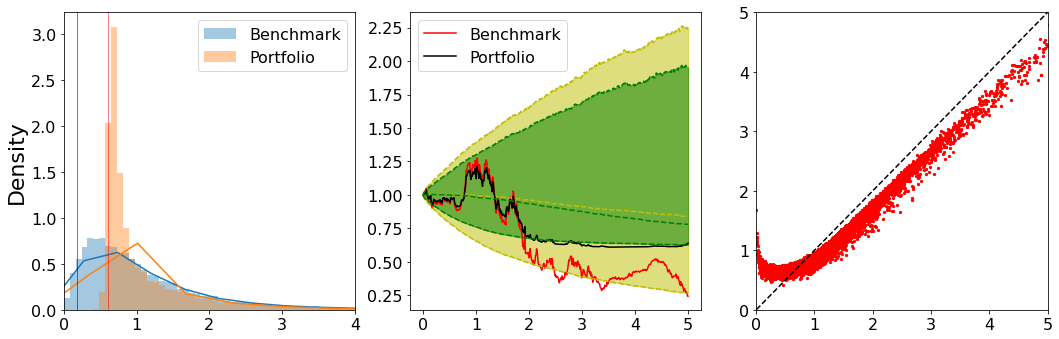

1.0582254 1.0388122

..........250 duaration =  10.884  secs
Wass Dist: 0.521 Risk Measure: -10.362 Loss: 41.752


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


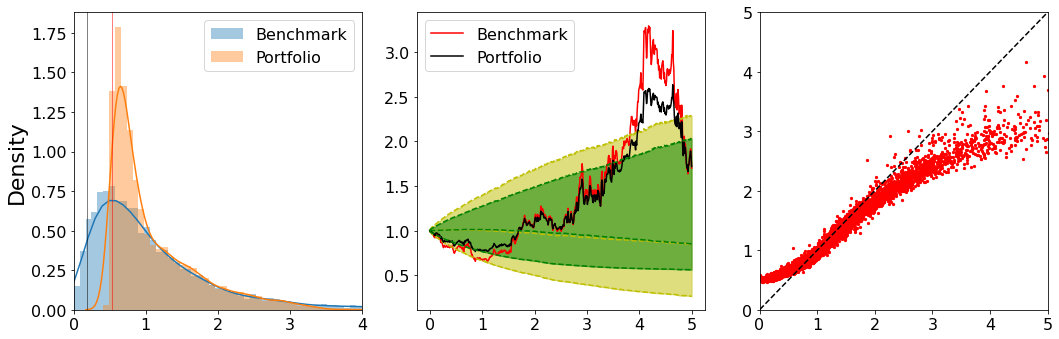

1.0617003 1.0429085

..........260 duaration =  10.669  secs
Wass Dist: 0.592 Risk Measure: -10.635 Loss: 48.600


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


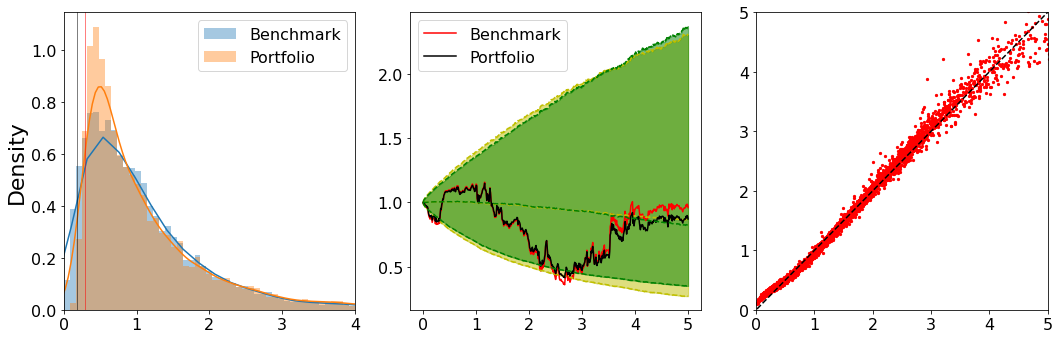

1.0594354 1.0533998

..........270 duaration =  10.788  secs
Wass Dist: 0.368 Risk Measure: -12.420 Loss: -12.420


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


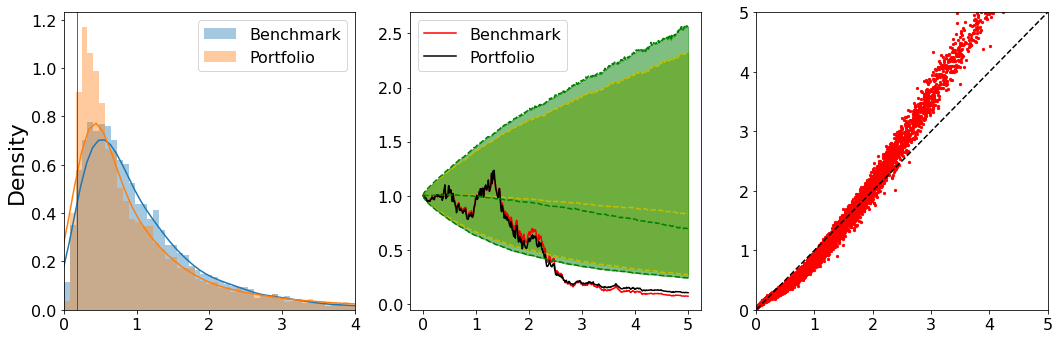

1.0783817 1.1020154

..........280 duaration =  10.925  secs
Wass Dist: 0.265 Risk Measure: -11.465 Loss: -11.465


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


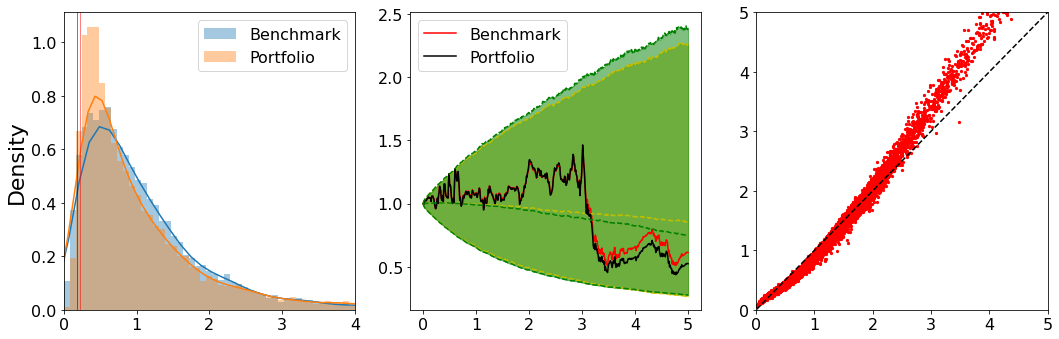

1.0881468 1.1011091

..........290 duaration =  10.826  secs
Wass Dist: 0.221 Risk Measure: -11.749 Loss: -11.749


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


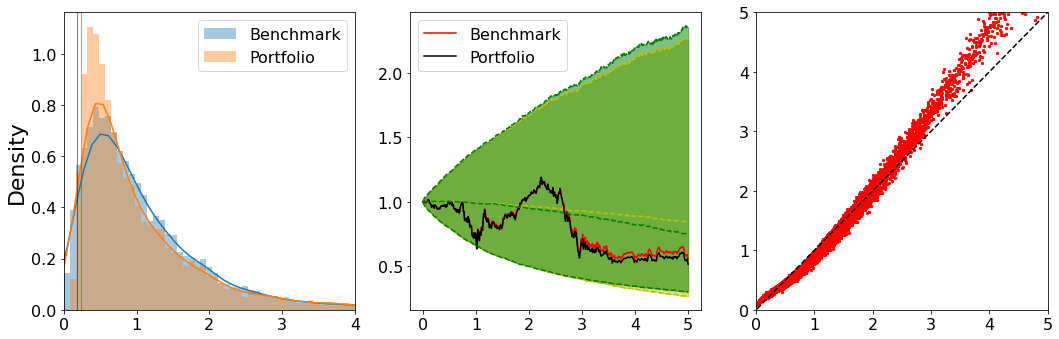

1.0595176 1.0654591

..........300 duaration =  10.795  secs
Wass Dist: 0.221 Risk Measure: -11.809 Loss: -11.809


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


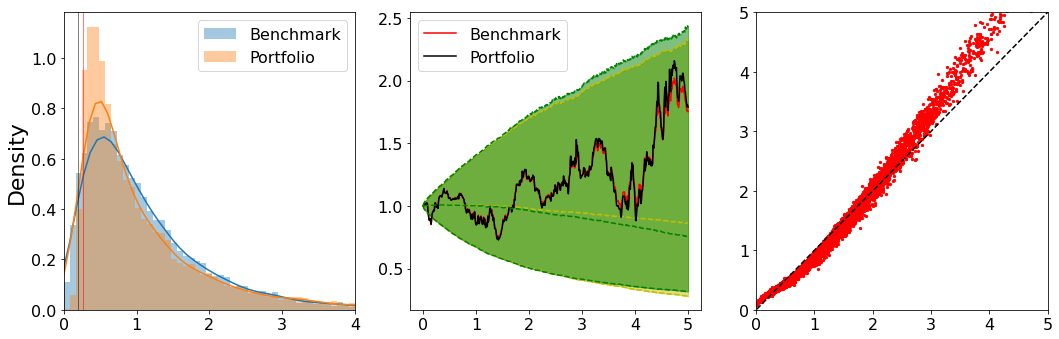

1.0727979 1.0776849

..........310 duaration =  10.973  secs
Wass Dist: 0.261 Risk Measure: -12.062 Loss: -12.062


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


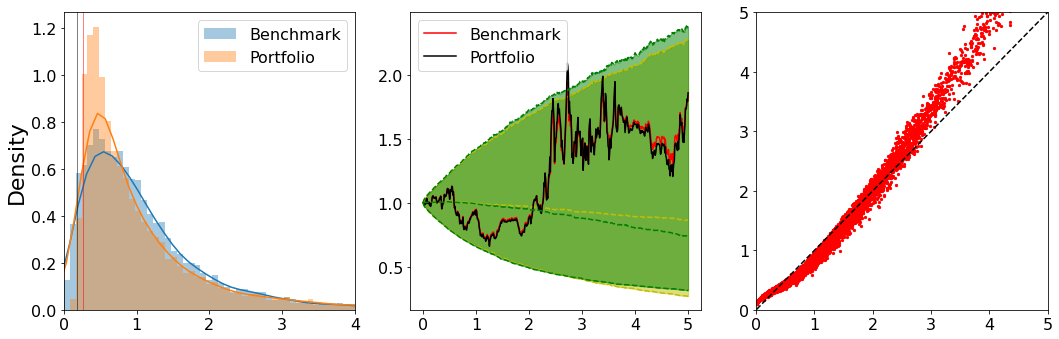

1.0693114 1.0751053

..........320 duaration =  10.923  secs
Wass Dist: 0.349 Risk Measure: -12.446 Loss: -12.446


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


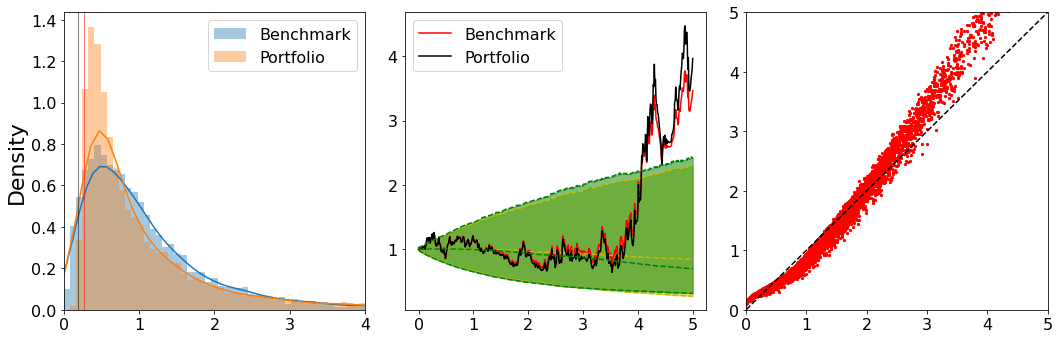

1.0816967 1.0932775

..........330 duaration =  10.988  secs
Wass Dist: 0.299 Risk Measure: -12.727 Loss: -12.727


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


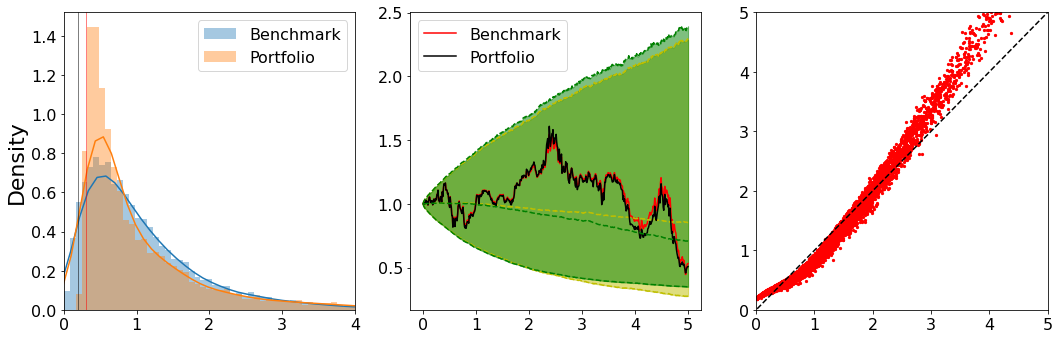

1.0590137 1.0651973

..........340 duaration =  10.834  secs
Wass Dist: 0.231 Risk Measure: -12.201 Loss: -12.201


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


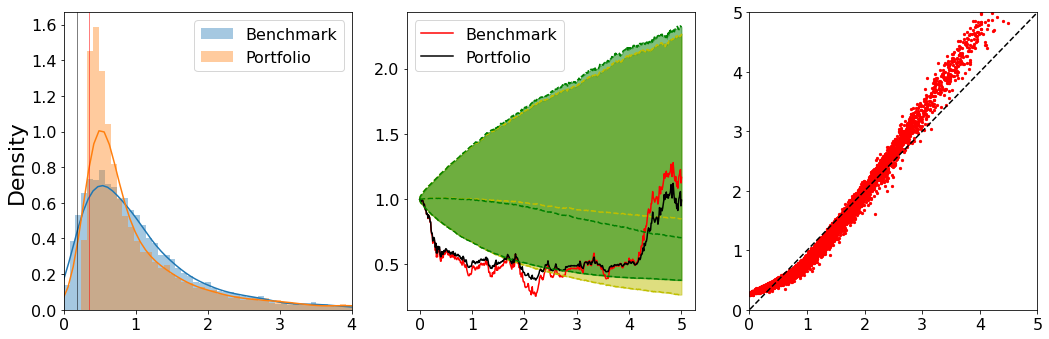

1.0763435 1.0793706

..........350 duaration =  10.831  secs
Wass Dist: 0.265 Risk Measure: -12.629 Loss: -12.629


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


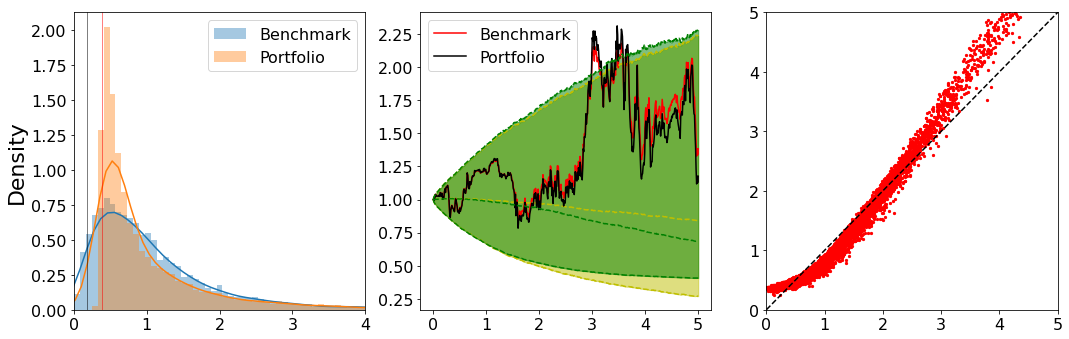

1.0585966 1.0615654

..........360 duaration =  10.846  secs
Wass Dist: 0.307 Risk Measure: -13.175 Loss: -13.175


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


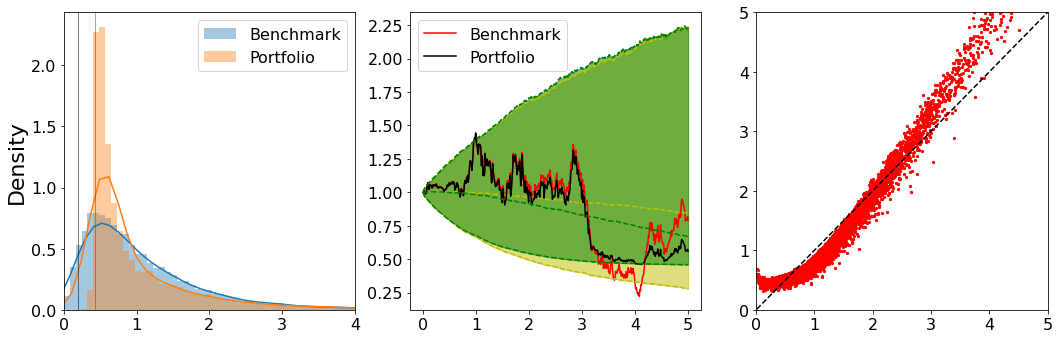

1.0657378 1.0684384

..........370 duaration =  10.782  secs
Wass Dist: 0.383 Risk Measure: -13.426 Loss: -13.426


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


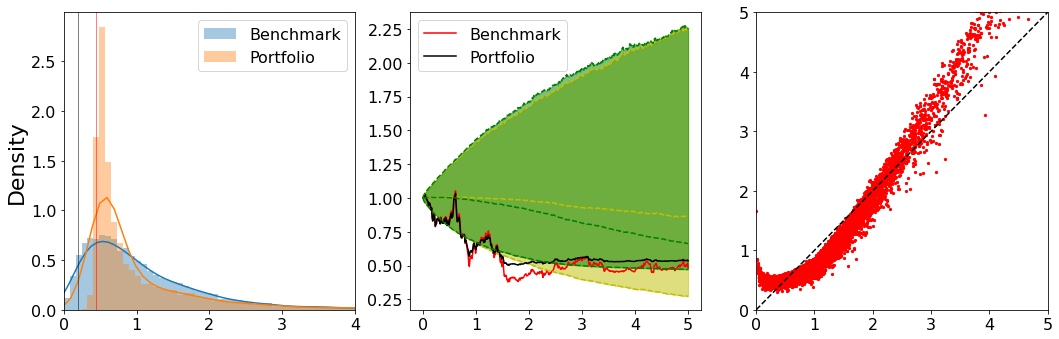

1.0723188 1.07583

..........380 duaration =  10.780  secs
Wass Dist: 0.313 Risk Measure: -13.170 Loss: -13.170


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


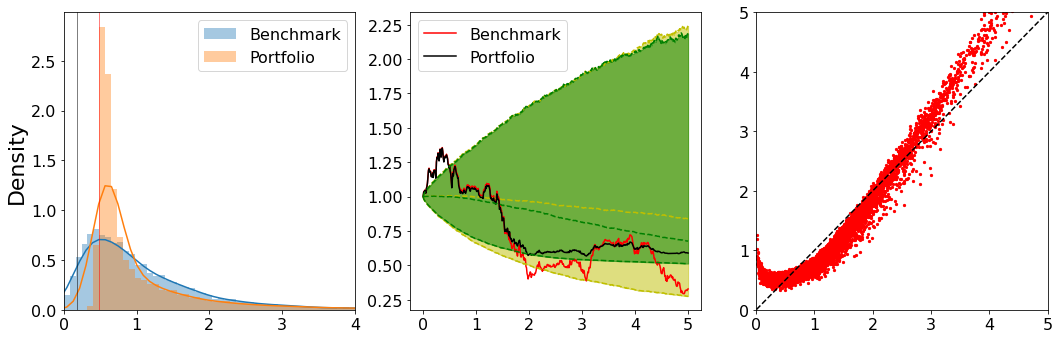

1.0765314 1.0737906

..........390 duaration =  10.880  secs
Wass Dist: 0.315 Risk Measure: -13.366 Loss: -13.366


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


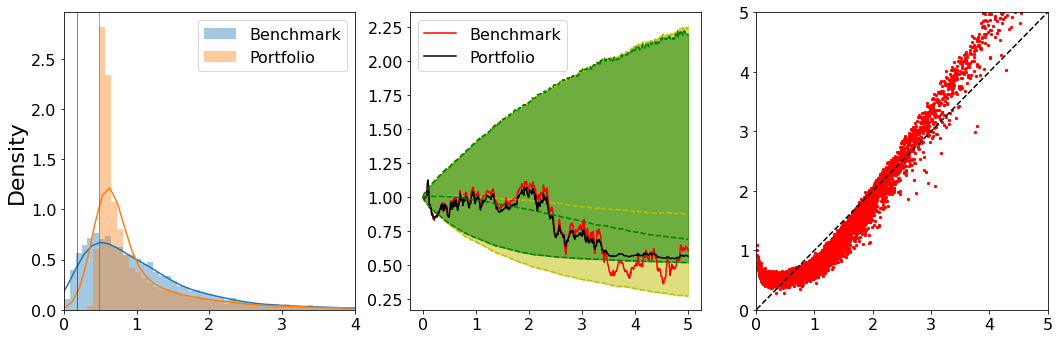

1.074739 1.0657105

..........400 duaration =  11.007  secs
Wass Dist: 0.369 Risk Measure: -13.508 Loss: -13.508


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


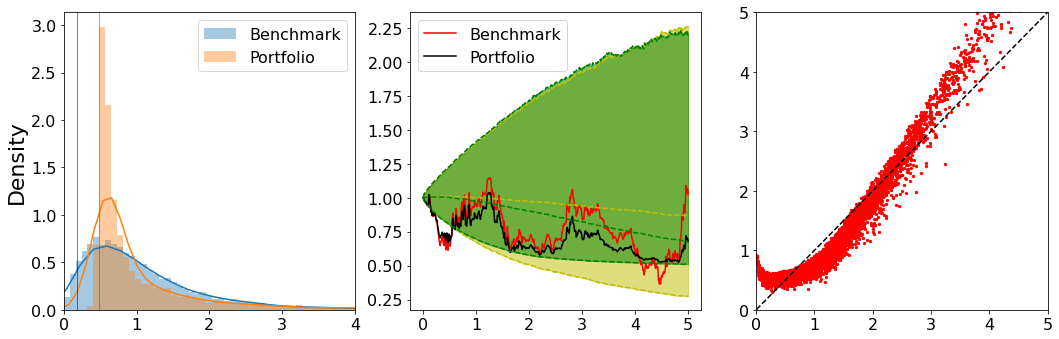

1.0796639 1.0785038

..........410 duaration =  10.917  secs
Wass Dist: 0.409 Risk Measure: -13.679 Loss: 27.237


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


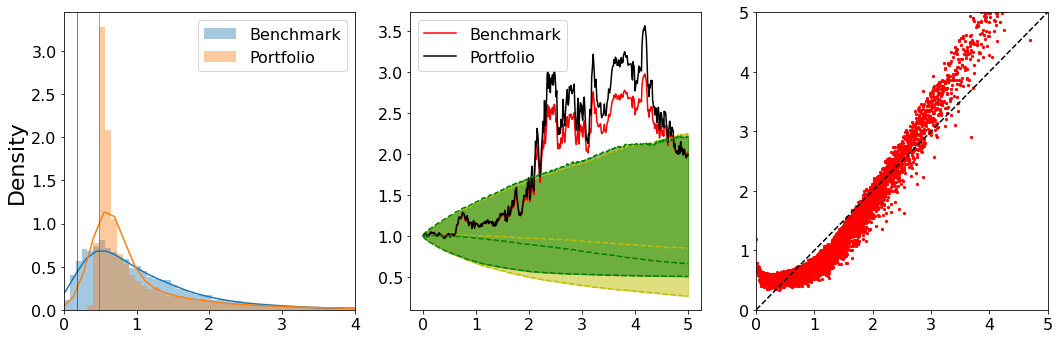

1.0676008 1.0574152

..........420 duaration =  10.860  secs
Wass Dist: 0.311 Risk Measure: -13.276 Loss: -13.276


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


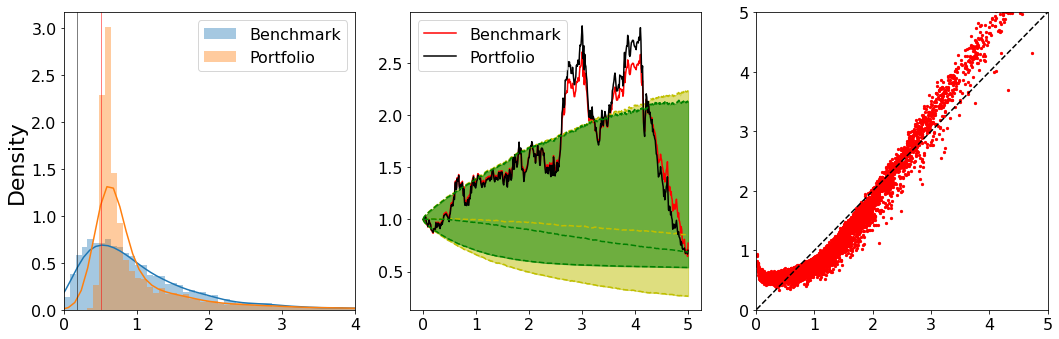

1.0811275 1.0767922

..........430 duaration =  10.932  secs
Wass Dist: 0.320 Risk Measure: -13.353 Loss: -13.353


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


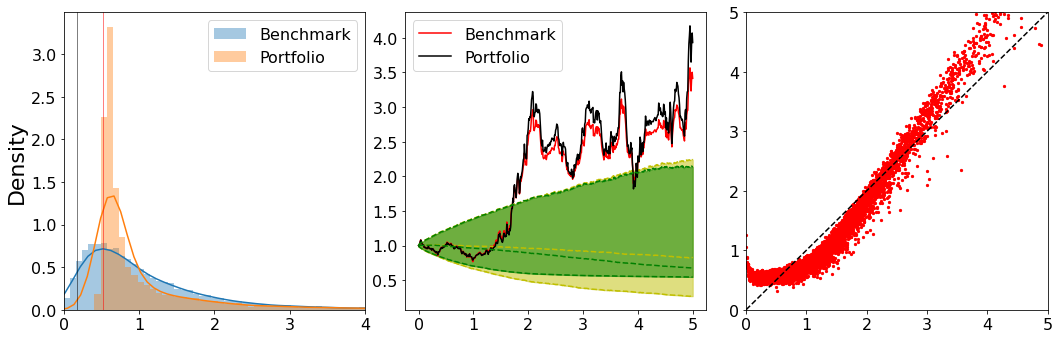

1.0936481 1.0935557

..........440 duaration =  10.966  secs
Wass Dist: 0.376 Risk Measure: -13.924 Loss: -13.924


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


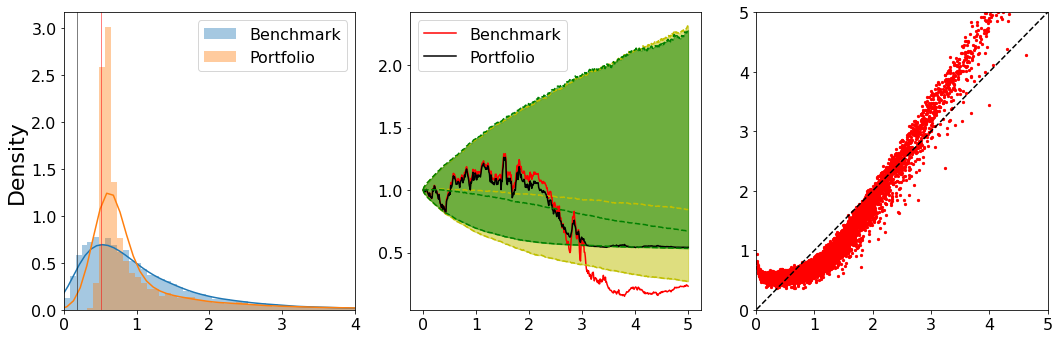

1.0725992 1.0667834

..........450 duaration =  10.901  secs
Wass Dist: 0.370 Risk Measure: -13.850 Loss: -13.850


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


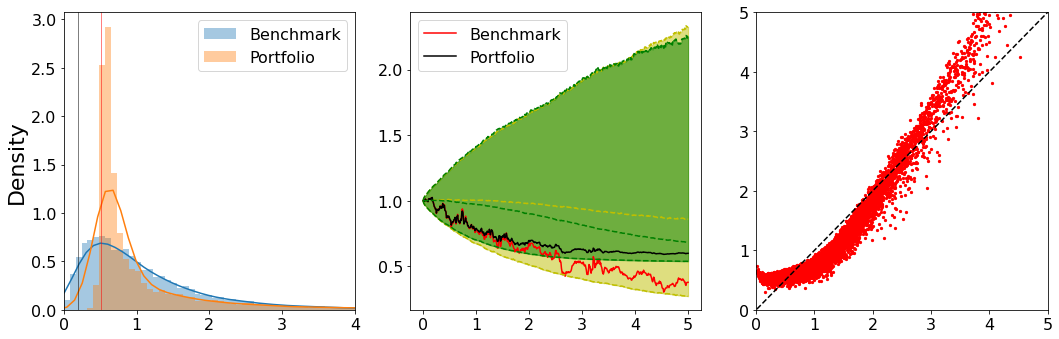

1.0884514 1.0879546

..........460 duaration =  10.783  secs
Wass Dist: 0.347 Risk Measure: -13.561 Loss: -13.561


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


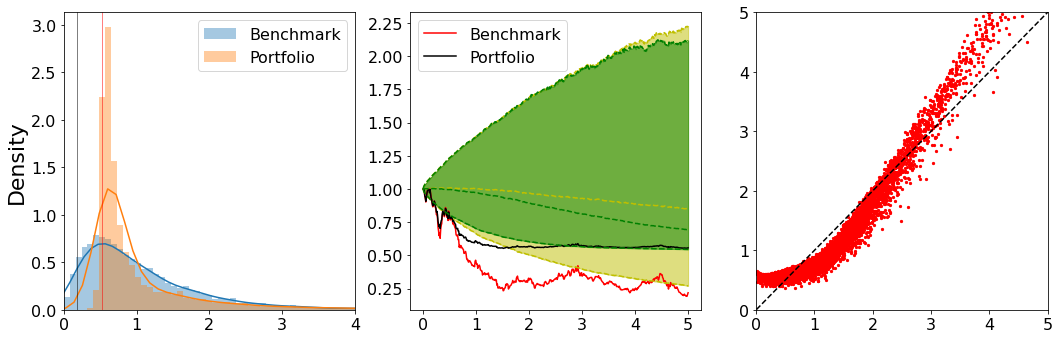

1.0822273 1.0798423

..........470 duaration =  10.878  secs
Wass Dist: 0.371 Risk Measure: -13.659 Loss: -13.659


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


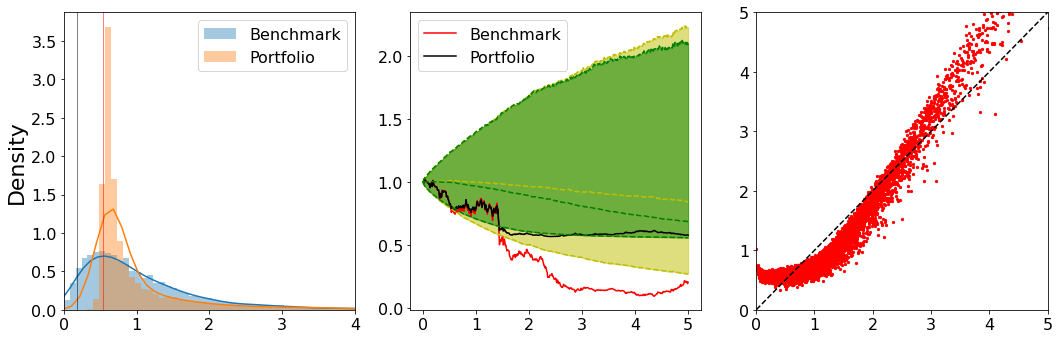

1.0809534 1.0785912

..........480 duaration =  10.776  secs
Wass Dist: 0.343 Risk Measure: -13.629 Loss: -13.629


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [ ]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs = 1000
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, RiskMeasure, wass_dist, PortfolioVal_T, IndexVal_T, t, IndexVal_path, PortfolioVal_path \
        = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
    #loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure +100*(wass_dist)*(wass_dist>0.15)
    loss = 100*(wass_dist)*(wass_dist>0.4) + RiskMeasure 
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 10 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()
        
        print("Wass Dist:", "{:.3f}".format(wass_dist_history[-1]), end=" " )
        print("Risk Measure:", "{:.3f}".format(risk_history[-1]), end=" ")
        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists(IndexVal_T, PortfolioVal_T, t, IndexVal_path, PortfolioVal_path)
                
        
        _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
        print(np.mean(np.exp(-params_Q["rf"]*5) * BenchmarkVal_T_Q.cpu().detach().numpy()), end=" ")
        print(np.mean(np.exp(-params_Q["rf"]*5) * PortfolioVal_T_Q.cpu().detach().numpy()), end="\n\n")        
        

print('Finished Training')

In [ ]:
X_pi_T = np.zeros((0,1))
X_delta_T = np.zeros((0,1))
for i in range(10):
    _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
    X_pi_T = np.concatenate((X_pi_T,PortfolioVal_T_Q.cpu().detach().numpy()))
    X_delta_T = np.concatenate((X_pi_T,BenchmarkVal_T_Q.cpu().detach().numpy()))
    
print(np.mean(np.exp(-params_Q["rf"]*5) * X_delta_T), end=" ")
print(np.mean(np.exp(-params_Q["rf"]*5) * X_pi_T), end="\n\n")  

In [ ]:
X_delta_T.shape

In [ ]:
def PlotStrat(net, device):
    
    t = np.linspace(0, 5, 100)
    X_delta_t = np.linspace(0.5, 3, 100)
     
    x1, x2 = np.meshgrid(t, X_delta_t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x1
    x[:,:,1] = x2
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(15,5))

    #params["delta"]
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        #Normalizing the weights to get the ratio of portfolio and benchmark weight
        ax.plot_surface(x1, x2, w_t[:,:,i]/params["delta"][i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('t')
        plt.ylabel('x')
    
    plt.tight_layout()
    plt.show()
    
    
    # for i in range(0,x1.shape[1],5):
    
    #     fig = plt.figure(figsize=(10,5))
    
    #     plt.subplot(1,3,1)
    #     plt.plot(X_delta_t, w_t[:,i,0])
        
    #     plt.subplot(1,3,2)
    #     plt.plot(X_delta_t, w_t[:,i,1])

    #     plt.subplot(1,3,3)
    #     plt.plot(X_delta_t, w_t[:,i,1])
        
    #     plt.suptitle("t={0:0.2f}".format(t[i]) , fontsize= 20 )
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #     plt.show()
    
    
PlotStrat(net, device)
    

### Backtesting

In [ ]:
#backtesting_params = params

# backtesting_params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.3]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }

backtesting_params = {
    "S0" : np.array([1, 1]),
    "mu" : np.array([0.05, 0.05]),
    "sigma" : np.array([0.1, 0.8]),
    "rho" : np.array([[1, .25],[.25,1]]),
    "rf" : 0.01,
    "delta" : np.array([0.5, 0.5])
    }

# backtesting_params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.30 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=1, params=backtesting_params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)

In [ ]:
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,0], label='Asset1', color='r')
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,1], label='Asset2', color='b')
plt.legend()

In [ ]:
wt

In [ ]:
#%debug

In [ ]:
import pickle 

In [ ]:
pickle.dump( net, open( "net_Nov2.p", "wb" ) )